In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#import tyssue
import sys
sys.path.append('/home/guillaume/Python/tyssue/src')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet

from tyssue.utils.utils import set_data_columns

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax



from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.io import hdf5

In [3]:
!ls ../leg_joint\ import


before_apoptosis.hf5		  iterate.dat	       small_xml.hf5
default_params.json		  nb_init.py
Import data from leg-joint.ipynb  small_hexagonal.hf5


In [4]:
h5store = '../leg_joint import/before_apoptosis.hf5'
_datasets = hdf5.load_datasets(h5store, data_names=['cell_df', 'jv_df', 'je_df'])

# translate
corresp = {
    'cell_df': 'face',
    'jv_df': 'jv',
    'je_df': 'je',}

datasets = {}
for old, new in corresp.items():
    datasets[new] = _datasets[old]

# Pass from multiIndex to flat
je_df_ = datasets['je']

je_df = je_df_.reset_index()
je_df['face'] = je_df['cell']

# Strip everything but the indexes
keep = ['srce', 'trgt', 'face']
je_df = je_df[keep]

del _datasets

In [5]:
je_df.head()

,srce,trgt,face
0,1,0,0
1,2,1,0
2,0,1,1
3,3,0,1
4,1,6,1


In [6]:
datasets.keys()

dict_keys(['jv', 'je', 'face'])

In [7]:
sheet = Sheet('pola', datasets)
geom_spec = geom.get_default_geom_specs()

set_data_columns(sheet, geom_spec)
geom.update_all(sheet, coords=sheet.coords)

ValueError: The `datasets` dictionnary should
            contain at least the 'cell', 'jv' and 'je' keys

In [49]:
mod_specs = model.get_default_mod_specs()
mod_specs['cell']['aspect'] = (6., np.float)
dim_mod_specs = model.dimentionalize(mod_specs)
set_data_columns(sheet, dim_mod_specs)
sheet.grad_norm_factor = dim_mod_specs['settings']['grad_norm_factor']
sheet.nrj_norm_factor = dim_mod_specs['settings']['nrj_norm_factor']
geom.update_num_sides(sheet)

isotropic_relax(sheet, **mod_specs)


In [50]:
%matplotlib inline

(-20.842163712540533, 20.629088066648414)

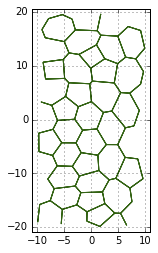

In [51]:
from tyssue.draw.mpl_draw import get_default_draw_specs
draw_specs = get_default_draw_specs()
draw_specs['jv']['visible'] = False
draw_specs['je']['width'] = 0.01


local_mask_jv = (sheet.jv_df.x.abs() < 20) & (sheet.jv_df.z.abs() < 10) & (sheet.jv_df.y > 0)
local_patch_jv = sheet.jv_df[local_mask_jv] 
local_patch_je = sheet.je_df[sheet.upcast_srce(local_mask_jv) & sheet.upcast_trgt(local_mask_jv)]
local_patch_cell = sheet.cell_df.loc[np.unique(local_patch_je.index.get_level_values('cell'))]
local_datasets = {'jv': local_patch_jv,
                  'je': local_patch_je,
                  'cell':local_patch_cell}
local_sheet = Sheet('local', local_datasets)

fig, ax = sheet_view(local_sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(local_sheet.jv_df.z.min()-1, local_sheet.jv_df.z.max()+1)
ax.set_ylim(local_sheet.jv_df.x.min()-1, local_sheet.jv_df.x.max()+1)

In [52]:



res = solver.find_energy_min(sheet, **settings)
print(res['success'])

True


In [53]:
center_jes = sheet.je_df[sheet.upcast_srce(sheet.jv_df['z']).abs() < 5].index

In [54]:
sheet.je_df.loc[center_jes, 'line_tension'] = (sheet.je_df.loc[center_jes, 'line_tension'] * 
                                               (3*np.sin(sheet.je_df.loc[center_jes, 'nz'])**2))

/home/guillaume/anaconda/envs/tyssue/lib/python3.4/site-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':
/home/guillaume/anaconda/envs/tyssue/lib/python3.4/site-packages/ipykernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app
/home/guillaume/anaconda/envs/tyssue/lib/python3.4/site-packages/ipykernel/kernelbase.py:213: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


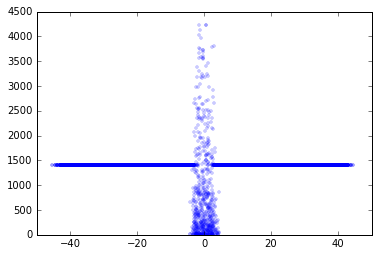

In [58]:
fig, ax = plt.subplots()
ax.plot(sheet.upcast_srce(sheet.jv_df['z']), sheet.je_df['line_tension'], '.', alpha=0.2)

In [56]:
settings = {
    'minimize': {
        'options': {'disp':True,
        'gtol':1e-2},
        'jac': solver.opt_grad
        }
    }
res = solver.find_energy_min(sheet, **settings)
print(res['success'])

True


(-19.328021719179496, 20.97766308065178)

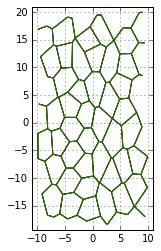

In [57]:
local_mask_jv = (sheet.jv_df.x.abs() < 20) & (sheet.jv_df.z.abs() < 10) & (sheet.jv_df.y > 0)
local_patch_jv = sheet.jv_df[local_mask_jv] 
local_patch_je = sheet.je_df[sheet.upcast_srce(local_mask_jv) & sheet.upcast_trgt(local_mask_jv)]
local_patch_cell = sheet.cell_df.loc[np.unique(local_patch_je.index.get_level_values('cell'))]
local_datasets = {'jv': local_patch_jv,
                  'je': local_patch_je,
                  'cell':local_patch_cell}
local_sheet = Sheet('local', local_datasets)

fig, ax = sheet_view(local_sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(local_sheet.jv_df.z.min()-1, local_sheet.jv_df.z.max()+1)
ax.set_ylim(local_sheet.jv_df.x.min()-1, local_sheet.jv_df.x.max()+1)